In [1]:
import numpy as np 
import xarray as xr 
import gsw
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import datetime as DT
import time
from tqdm.notebook import tqdm
import glob
import warnings 
warnings.filterwarnings('ignore')

In [2]:
step = 1
cen_lon = np.arange(125,175+step,step)    # center_latitude (in degrees)
cen_lat = np.arange(10,50+step,step)      # center longitude (in degrees)
p_grid = np.arange(0,2000,10)
rho_grid = np.arange(24,32.5,0.1)
z_grid = gsw.z_from_p(p_grid,30)
this_year = ['2009', '2010', '2011', '2012', '2013', \
             '2014', '2015', '2016', '2017', '2018']  
# this_month = ['01', '02', '03', '04', '12']
# this_month = ['05', '06', '07', '08', '09', '10']
this_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# select desired times 
this_month_int = np.nan * np.ones(len(this_month))
for i in range(len(this_month)):
    this_month_int[i] = np.int(this_month[i])

In [6]:
# loop over files, find profiles that fall within specified lat/lon grid, place on regular pressure grid 
count = 0
temp_out = []
salin_out = []
lon_p_out = []
lat_p_out = []
time_p_out = []
count_out = []
for y in tqdm(range(len(this_year))):  # loop over year
    for m in range(len(this_month)):   # loop over month 
        data_files = glob.glob('/Users/jakesteinberg/Documents/CPT/Argo/pacific_' + this_year[y] + '/' + this_month[m] + '/*.nc')
        for d in range(len(data_files)): # loop over day 
            test = xr.open_dataset(data_files[d])
            this_lon_m = test['LONGITUDE']
            this_lat_m = test['LATITUDE']
            inn = np.where((this_lon_m > (np.nanmin(cen_lon)-2*step)) & (this_lon_m < (np.nanmax(cen_lon)+2*step)) & \
                     (this_lat_m > (np.nanmin(cen_lat)-2*step)) & (this_lat_m < (np.nanmax(cen_lat)+2*step)))[0]
            if len(inn) < 1:
                continue 

            if count < 1:
                this_temp = np.nan*np.ones((len(p_grid), len(inn)))
                this_salin = np.nan*np.ones((len(p_grid), len(inn)))
                this_CT = np.nan*np.ones((len(p_grid), len(inn)))
                this_SA = np.nan*np.ones((len(p_grid), len(inn)))
                this_sigma1 = np.nan*np.ones((len(p_grid), len(inn)))
                this_temp_rho = np.nan*np.ones((len(rho_grid), len(inn)))
                this_salin_rho = np.nan*np.ones((len(rho_grid), len(inn)))
                r_temp = np.transpose(test['TEMP_ADJUSTED'].data[inn, :])
                r_sal = np.transpose(test['PSAL_ADJUSTED'].data[inn, :])
                r_pres = np.transpose(test['PRES_ADJUSTED'].data[inn, :])
                this_lon = test['LONGITUDE'].data[inn]
                this_lat = test['LATITUDE'].data[inn]
                this_time = test['JULD'].data[inn]
                max_pressure = np.nan*np.ones((len(inn)))
                for i in range(len(inn)):
                    this_temp[:, i] = np.interp(p_grid, r_pres[:, i], r_temp[:, i])   # temp on p_grid
                    this_salin[:, i] = np.interp(p_grid, r_pres[:, i], r_sal[:, i])   # sal on p_grid
                    max_pressure[i] = np.nanmax(r_pres[:, i])                         # max press of profile
                    this_SA[:, i] = gsw.SA_from_SP(this_salin[:,i], p_grid, this_lon[i], this_lat[i])
                    this_CT[:, i] = gsw.CT_from_t(this_SA[:, i], this_temp[:,i], p_grid)
                    this_sigma1[:, i] = gsw.density.sigma1(this_SA[:, i], this_CT[:, i])
                    this_temp_rho[:, i] = np.interp(rho_grid, this_sigma1[:, i], this_CT[:,i])   # temp on rho_grid
                    this_salin_rho[:, i] = np.interp(rho_grid, this_sigma1[:, i], this_SA[:,i])   # sal on rho_grid
            else:   
                this_temp_0 = np.nan*np.ones((len(p_grid), len(inn)))
                this_salin_0 = np.nan*np.ones((len(p_grid), len(inn)))
                this_CT_0 = np.nan*np.ones((len(p_grid), len(inn)))
                this_SA_0 = np.nan*np.ones((len(p_grid), len(inn)))
                this_sigma1_0 = np.nan*np.ones((len(p_grid), len(inn)))
                this_temp_rho_0 = np.nan*np.ones((len(rho_grid), len(inn)))
                this_salin_rho_0 = np.nan*np.ones((len(rho_grid), len(inn)))
                r_temp = np.transpose(test['TEMP_ADJUSTED'].data[inn, :])
                r_sal = np.transpose(test['PSAL_ADJUSTED'].data[inn, :])
                r_pres = np.transpose(test['PRES_ADJUSTED'].data[inn, :])
                this_lon_0 = test['LONGITUDE'].data[inn]
                this_lat_0 = test['LATITUDE'].data[inn]
                this_time_0 = test['JULD'].data[inn]
                max_pressure_0 = np.nan*np.ones((len(inn)))
                for i in range(len(inn)):
                    this_temp_0[:, i] = np.interp(p_grid, r_pres[:, i], r_temp[:, i])
                    this_salin_0[:, i] = np.interp(p_grid, r_pres[:, i], r_sal[:, i])
                    max_pressure_0[i] = np.nanmax(r_pres[:, i])
                    this_SA_0[:, i] = gsw.SA_from_SP(this_salin_0[:,i], p_grid, this_lon_0[i], this_lat_0[i])
                    this_CT_0[:, i] = gsw.CT_from_t(this_SA_0[:, i], this_temp_0[:,i], p_grid)
                    this_sigma1_0[:, i] = gsw.density.sigma1(this_SA_0[:, i], this_CT_0[:, i])
                    this_temp_rho_0[:, i] = np.interp(rho_grid, this_sigma1_0[:, i], this_CT_0[:, i])   # temp on rho_grid
                    this_salin_rho_0[:, i] = np.interp(rho_grid, this_sigma1_0[:, i], this_SA_0[:, i])   # sal on rho_grid
                this_temp = np.concatenate((this_temp, this_CT_0), axis=1)
                this_salin = np.concatenate((this_salin, this_SA_0), axis=1)
                this_sigma1 = np.concatenate((this_sigma1, this_sigma1_0), axis=1)
                this_temp_rho = np.concatenate((this_temp_rho, this_temp_rho_0), axis=1)
                this_salin_rho = np.concatenate((this_salin_rho, this_salin_rho_0), axis=1)
                this_lon = np.concatenate((this_lon, this_lon_0))
                this_lat = np.concatenate((this_lat, this_lat_0))
                this_time = np.concatenate((this_time, this_time_0))
                max_pressure = np.concatenate((max_pressure, max_pressure_0))
            del inn     
            count = count + 1
# -------------------------------
filename = ('/Users/jakesteinberg/Desktop/ss' + str(np.int(np.nanmin(cen_lon))) + '_' + str(np.int(np.nanmax(cen_lon))) + \
           'E_' + str(np.int(np.nanmin(cen_lat))) + '_' + str(np.int(np.nanmax(cen_lat))) + 'N_' + \
            this_year[0] + '_' + this_year[-1] + '_w_rho.nc')
ds = xr.Dataset(
    data_vars=dict(
        CT=(["z", "prof"], this_temp),
        SA=(["z", "prof"], this_salin),
        sigma1=(["z", "prof"], this_sigma1),
        temperature_rho=(["rho", "prof"], this_temp_rho),
        salinity_rho=(["rho", "prof"], this_salin_rho),
        max_pressure=(["prof"], max_pressure),
    ),
    coords=dict(
        pressure=(["z"], p_grid),
        density=(["rho"], rho_grid),
        latitude=(["prof"], this_lat),
        longitude=(["prof"], this_lon),
        time=(["prof"], this_time),
    ),
)
ds.to_netcdf(path=filename)

In [3]:
# radius = 75       # km radius of circle to consider  (75)
# sigma = 40        # decay for weighting function (km) (40)
# n_to_cons = 900   # max number of profiles to consider within each circle (limitor, may generate an error)
# pressure_limit = 1200
# data_file = xr.open_dataset('/Users/jakesteinberg/Documents/CPT/Argo/ss130_159E__20_44N_2013_2015.nc')
# data_file = xr.open_dataset('/Users/jakesteinberg/Desktop/ss135.0_154.0E__24.0_40.0N_2013_2014.nc')

def nearby_profiles(file_path, radius, sigma, n_to_cons, this_month_int, pressure_limit):
    data_file = xr.open_dataset(file_path)
    m_time = data_file.time.data
    m_years = m_time.astype('datetime64[Y]').astype(int) + 1970
    m_months = m_time.astype('datetime64[M]').astype(int) % 12 + 1
    m_t_in = np.in1d(m_months,this_month_int)
    m_lon = data_file.longitude.data[m_t_in]  # test['LONGITUDE']
    m_lat = data_file.latitude.data[m_t_in]  # test['LATITUDE']
    m_max_pressure = data_file.max_pressure.data[m_t_in]
    m_temp = data_file.CT.data[:, m_t_in]
    m_salin = data_file.SA.data[:, m_t_in]
    m_sigma = data_file.sigma1.data[:, m_t_in]
    m_temp_rho = data_file.temperature_rho.data[:, m_t_in]
    m_salin_rho = data_file.salinity_rho.data[:, m_t_in]
    m_time = data_file.time.data[m_t_in]

    temp_out = []
    salin_out = []
    rho_out = []
    temp_rho_out = []
    salin_rho_out = []
    lon_p_out = []
    lat_p_out = []
    time_p_out = []
    count_out = []
    weights_out = []
    mp_out = []
    c_lon_out = np.nan*np.ones(len(cen_lon)*len(cen_lat))
    c_lat_out = np.nan*np.ones(len(cen_lon)*len(cen_lat))
    master_count = 0
    for c_lon_i in tqdm(range(len(cen_lon))):
        this_cen_lon = cen_lon[c_lon_i]
        for c_lat_i in range(len(cen_lat)):
            this_cen_lat = cen_lat[c_lat_i]
            weight = np.nan*np.ones(n_to_cons)
            dx = (m_lon - this_cen_lon)*np.cos(np.deg2rad(this_cen_lat))*60*1852
            dy = (m_lat - this_cen_lat)*60*1852
            dist_to_center = np.sqrt(dx**2 + dy**2)
            inn = np.where((dist_to_center/1000 <= radius) & (m_max_pressure > pressure_limit))[0]
            if len(inn) > 0:
                weight = np.exp(-((dist_to_center[inn]/1000)**2)/(2*sigma**2))
                temp = m_temp[:, inn]
                salin = m_salin[:, inn]
                rho = m_sigma[:, inn]
                temp_rho = m_temp_rho[:, inn]
                salin_rho = m_salin_rho[:, inn]
                lon_p = m_lon[inn]
                lat_p = m_lat[inn]
                time_p = m_time[inn]
                mp = m_max_pressure[inn]
            else:
                temp = 'N/A'
                salin = 'N/A'
                rho = 'N/A'
                temp_rho = 'N/A'
                salin_rho = 'N/A'
                lon_p = 'N/A'
                lat_p = 'N/A'
                weight = 'N/A'
                time_p = 'N/A'
                mp = 'N/A'
                inn = [0]
        
            temp_out.append(temp)
            salin_out.append(salin)
            rho_out.append(rho)
            temp_rho_out.append(temp_rho)
            salin_rho_out.append(salin_rho)
            lon_p_out.append(lon_p)
            lat_p_out.append(lat_p)
            mp_out.append(mp)
            weights_out.append(weight)
            time_p_out.append(time_p)
            count_out.append(len(inn))
            c_lon_out[master_count] = this_cen_lon
            c_lat_out[master_count] = this_cen_lat
            master_count = master_count+1
    
    return temp_out, salin_out, rho_out, temp_rho_out, salin_rho_out, lon_p_out, lat_p_out, \
        weights_out, time_p_out, count_out, c_lon_out, c_lat_out, mp_out, master_count

In [4]:
file_path = '/Users/jakesteinberg/Documents/CPT/Argo/processed/ss125_175E_10_50N_2009_2018_w_rho.nc'
r = 150
sigma = r/2
n_to_cons = 750
p_lim = 1100
t_o, s_o, rho_o, t_rho_o, s_rho_o, \
    lon_o, lat_o, wt_o, time_o, count_o, c_lon_o, c_lat_o, mp, mc = nearby_profiles(file_path, r, sigma, \
                                                                                n_to_cons, this_month_int, p_lim)

In [5]:
test_ind = 2465
print(str(c_lon_o[test_ind]) + 'E, ' + str(c_lat_o[test_ind]) + 'N')

140.0E, 27.5N


In [7]:
# str(dates[0])[0:10]

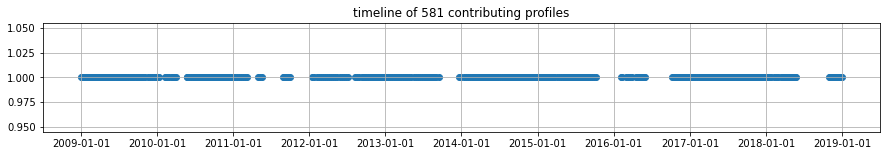

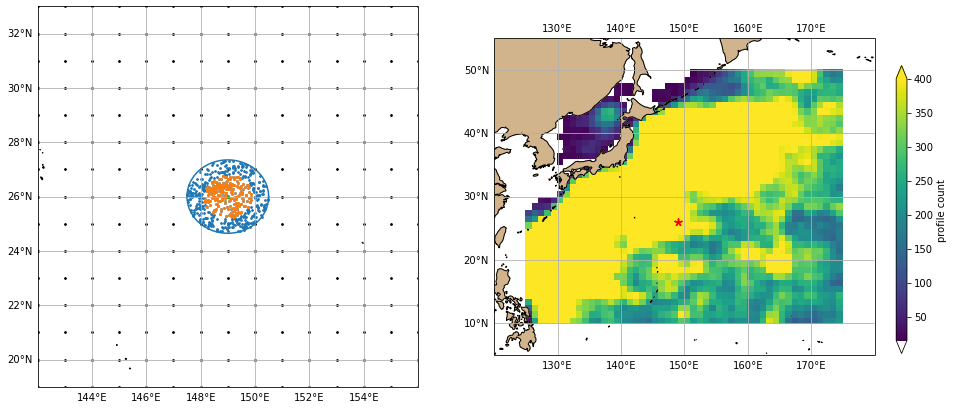

In [5]:
this_loc = 1000 # 3184 # 5385 # 4565  # 2070  # 2106
lon_grid, lat_grid = np.meshgrid(cen_lon, cen_lat)

# dates = [DT.datetime.strptime(str(int(date)),'%Y%m%d') for date in time_p_out[this_loc][0:count_out[this_loc]]]
dates = time_o[this_loc]
f, ax = plt.subplots(1,1,figsize=(15,2))
ax.scatter(dates, np.ones(count_o[this_loc]))
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
# ax.set_xticks(dates)
plt.xticks(rotation=0,fontsize=10)
ax.set_title('timeline of ' + str(count_o[this_loc]) + ' contributing profiles')
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_05_28/sample_timeline.jpg', dpi=550)

 
f, (ax,ax2) = plt.subplots(1,2,figsize=(15,8),subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
ax.scatter(lon_grid, lat_grid, color='k',s=3)
ax.scatter(lon_o[this_loc],lat_o[this_loc],s=3)
ax.scatter(lon_o[this_loc][wt_o[this_loc] > 0.5], lat_o[this_loc][wt_o[this_loc] > 0.5],s=3)
ax.scatter(c_lon_o[this_loc], c_lat_o[this_loc], s=7)
angle = np.linspace( 0 , 2 * np.pi , 150 ) 
r_check = r*1000
x = r_check * np.cos(angle) 
y = r_check * np.sin(angle) 
circ_lon = x/(1852*60*np.cos(np.deg2rad(c_lat_o[this_loc]))) + c_lon_o[this_loc]
circ_lat = y/(1852*60) + c_lat_o[this_loc]
ax.plot(circ_lon, circ_lat)
ax.set_extent([c_lon_o[this_loc] - 7, c_lon_o[this_loc] + 7, \
               c_lat_o[this_loc] - 7, c_lat_o[this_loc] + 7], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

# how many profiles contributing to each measurement 
master_count = 0
float_den = np.nan * np.ones((len(cen_lat), len(cen_lon)))
for ii in tqdm(range(len(cen_lon))):
    for jj in range(len(cen_lat)):
        float_den[jj,ii] = count_o[master_count]
        master_count = master_count + 1
cmap = plt.get_cmap('viridis')
cmap.set_under("w")
fd = ax2.pcolor(cen_lon,cen_lat,float_den,transform=ccrs.PlateCarree(),vmin=15, vmax=400,cmap=cmap)
ax2.scatter(c_lon_o[this_loc], c_lat_o[this_loc], s=50, color='r', marker=(5, 2))
ax2.set_extent([np.nanmin(cen_lon)-5, np.nanmax(cen_lon)+5, \
              np.nanmin(cen_lat)-5, np.nanmax(cen_lat)+5], crs=ccrs.PlateCarree())
gl = ax2.gridlines(draw_labels=True)
gl.ylabels_right = False
cbpos = [0.92, 0.23, 0.01, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(fd, cax=cax, orientation='vertical', extend='both', label='profile count')
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax2.coastlines()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_05_28/sample_in_profiles', dpi=550)


for each profile within circle centered at center_lon, center_lat, calculate

- absolute salinity
- conservative temperature
- potential density referenced to 1000m ($\sigma$)
- n2
- isopycnal vertical displacement = 
### $\xi(x,y,z)$ = $\frac{\left( \sigma - \overline{\sigma} \right)}{\frac{\partial \overline{\sigma}}{\partial z}}$
- available potential energy = 
### $\frac{-g}{2\rho_0} \xi(x,y,z) \sigma'(x,y,z)$

In [6]:
# compute density and displacement
month_bound = 6 # number of months +/- this profile to average over for mean rho 
# if zero mean density profile is entire time average 

lon_grid, lat_grid = np.meshgrid(cen_lon, cen_lat)
mean_rho = np.nan*np.ones((len(cen_lon), len(cen_lat), len(z_grid)))
mean_t_on_rho = np.nan*np.ones((len(cen_lon), len(cen_lat), len(rho_grid)))
mean_s_on_rho = np.nan*np.ones((len(cen_lon), len(cen_lat), len(rho_grid)))
ape = np.nan*np.ones((len(cen_lon), len(cen_lat), len(z_grid)))
ape2 = np.nan*np.ones((len(cen_lon), len(cen_lat), len(z_grid)))
ape3 = np.nan*np.ones((len(cen_lon), len(cen_lat), len(z_grid)))
rho_out = []
rho_prime_out = []
n2_out = []
eta_out = []
eta2_out = []
ape2_out = []
ape3_out = []
master_count = 0
time0 = time.time()
for ii in tqdm(range(len(cen_lon))):
    for jj in range(len(cen_lat)):
        if count_o[master_count] > 1:
            
            SA = s_o[master_count]
            CT = t_o[master_count]
            rho1000 = rho_o[master_count]
    
            # -- some QC
            bad = np.where((np.nanmean(rho1000[0:20,:], axis=0) > 31) | \
                           (np.nanmean(rho1000[0:20,:], axis=0) < 25))[0]
            if len(bad) > 0:
                rho1000[:, bad] = np.nan
    
            # n2, p_mid = gsw.Nsquared(np.nanmean(SA,axis=1), np.nanmean(CT,axis=1), p_grid, lat=c_lat_out[master_count])
        
            # -- calculate mean density profile as that +/- desired number of months bounding current profile 
            # -- time (all times in this region)
            test_date = []
            for i in range(len(time_o[master_count])):
                test_date.append(DT.datetime.utcfromtimestamp(time_o[master_count][i].tolist()/1e9))
            test_date = np.array(test_date)
            
            rho_bar_0 = np.nanmean(rho1000,axis=1)
            # rho_prime = rho1000 - np.tile(rho_bar[:, None],(1,count_out[master_count]))
            # OLD drho_dz = np.nan * np.ones(np.shape(rho_bar))
            # OLD drho_dz[1:-1] = (rho_bar[2:] - rho_bar[0:-2])/(z_grid[2]-z_grid[0])
            # OLD eta = np.nan*np.ones(np.shape(rho_prime))   
            eta_2 = np.nan*np.ones(np.shape(rho1000))
            rho_prime = np.nan*np.ones(np.shape(rho1000))
            n2 = np.nan*np.ones(np.shape(rho1000))
            # loop over each profile 
            for i in range(count_o[master_count]):
                this_t = time_o[master_count][i]
                # year_back = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).year - 1 
                # month_back = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).month
                # if (month_back == 2) & (DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).day > 2):
                #     day_back = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).day - 1
                # else:
                #     day_back = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).day
                # date_back = DT.datetime(year_back, month_back, day_back)      
                # year_for = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).year + 1 
                # month_for = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).month
                # if (month_for == 2) & (DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).day > 2):
                #     day_for = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).day - 1
                # else:
                #     day_for = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9).day
                # date_for = DT.datetime(year_for, month_for, day_for)    
                if month_bound > 0:
                    date_back = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9 - 60*60*24*30*month_bound)
                    date_for = DT.datetime.utcfromtimestamp(this_t.tolist()/1e9 + 60*60*24*30*month_bound)              
                    rho_bar_i = np.where((test_date > date_back) & (test_date < date_for))[0]
                    rho_bar = np.nanmean(rho1000[:, rho_bar_i], axis=1)
                    n2_mid, p_mid = gsw.Nsquared(np.nanmean(SA[:, rho_bar_i],axis=1), \
                                             np.nanmean(CT[:, rho_bar_i],axis=1), p_grid, lat=c_lat_o[master_count])
                else:
                    rho_bar = np.nanmean(rho1000, axis=1)
                    n2_mid, p_mid = gsw.Nsquared(np.nanmean(SA,axis=1), np.nanmean(CT,axis=1), \
                                                 p_grid, lat=c_lat_o[master_count])
                
                n2[:, i] = np.interp(p_grid, p_mid, n2_mid)
                rho_prime[:, i] = rho1000[:, i] - rho_bar
                
                # -- at each depth look at density at this depth and find the depth of that density on the mean profile 
                for j in range(len(z_grid)):
                    this_rho = rho1000[j,i]
                    mean_prof_ref = np.where(rho_bar >= this_rho)[0]
                    if (len(mean_prof_ref) > 0):
                        if (mean_prof_ref[0] > 0) & (mean_prof_ref[0] < (len(rho_bar)-1)):
                            back_z = np.interp(this_rho, \
                                               [rho_bar[mean_prof_ref[0]-1], rho_bar[mean_prof_ref[0]+1]], \
                                               [z_grid[mean_prof_ref[0]-1], z_grid[mean_prof_ref[0]+1]])
                            eta_2[j,i] = -1*(z_grid[j] - back_z)
               
            # -- to save time and space can comment out these variables 
            # (for large smoothing factors, can be very large)
            # rho_out.append(rho1000)
            # rho_prime_out.append(rho_prime)
            # OLD n2_out.append(np.concatenate((n2[:, None], p_mid[:, None]), axis=1))
            # OLD eta_out.append(eta)
            # eta2_out.append(eta_2)
            # ape2_out.append((-9.81/(2*1000))*eta_2*rho_prime)
            # ape3_out.append((eta_2**2)*(n2))
        
            mean_rho[ii,jj,:] = rho_bar_0  # total time mean density profile 
            mean_t_on_rho[ii,jj,:] = np.nanmean(t_rho_o[master_count], axis=1)
            mean_s_on_rho[ii,jj,:] = np.nanmean(s_rho_o[master_count], axis=1)
            this_weight = wt_o[master_count][0:count_o[master_count]]
            # OLD ape[ii,jj,:] = np.nansum((-9.81/(2*1000))*eta*rho_prime*\
            #                       np.tile(this_weight,(len(z_grid), 1)),axis=1)/count_out[master_count]
            ape2[ii,jj,:] = np.nansum((-9.81/(2*1000))*eta_2*rho_prime*\
                                  np.tile(this_weight,(len(z_grid), 1)),axis=1)/count_o[master_count]
            ape3[ii,jj,:] = np.nansum((eta_2**2)*(n2)*\
                                  np.tile(this_weight,(len(z_grid), 1)),axis=1)/count_o[master_count]
        else:
            rho_out.append('N/A')
            rho_prime_out.append('N/A')
            n2_out.append('N/A')
            eta_out.append('N/A')
            eta2_out.append('N/A')
            ape2_out.append('N/A')
            ape3_out.append('N/A')
        master_count = master_count + 1
time1 = time.time()
print(time1 - time0)


1991.2152791023254


IndexError: list index out of range

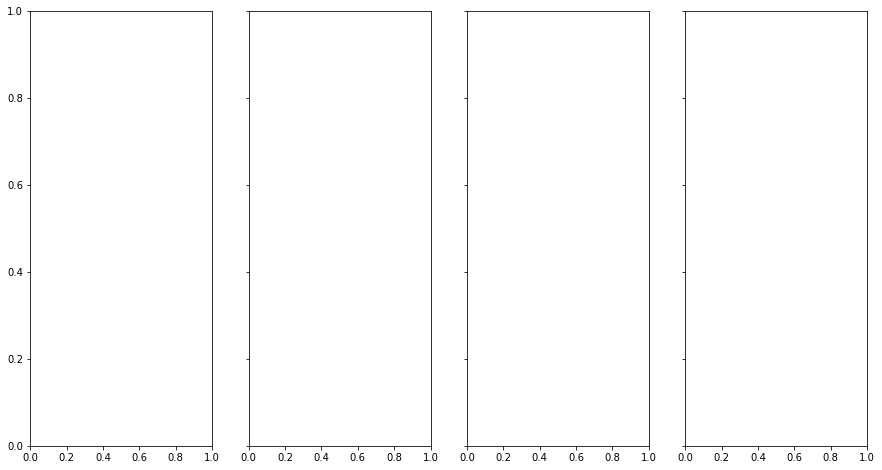

In [7]:
# single eta check
this_loc = 1000 # 3185 # 5385 # 3395 # 3517 # 4565  # 2070 # 2863  # 1830
loc_t_sort = np.argsort(time_o[this_loc])

bml = np.where(z_grid < -150)[0]
z_sub = z_grid[bml]
dep_of_max = np.nan * np.ones((np.shape(ape)[0], np.shape(ape)[1]))
for i in range(np.shape(ape)[0]):
    for j in range(np.shape(ape)[1]):
        # search for peak depth 
        max_i = np.where(ape2[i,j,bml] == np.nanmax(ape2[i,j,bml]))[0]
        if (len(max_i) > 0) & (np.nanmax(ape2[i,j,bml]) > 0.01):
            dep_of_max[i,j] = z_sub[max_i]

if len(time_o[this_loc]) < 40:
    ntp = len(time_o[this_loc])
else:
    ntp = 40
p_s = 0    

f, (ax2,ax4,ax,ax3) = plt.subplots(1,4,figsize=(15,8),sharey=True)
c_eta = plt.get_cmap('plasma',ntp)
for i in range(p_s, p_s+ntp):
    # ax[i].plot(eta_out[this_loc][:, loc_t_sort[1+i]], z_grid)
    ax.plot(eta2_out[this_loc][:, loc_t_sort[i]], z_grid, color=c_eta(i), \
            label=str(time_o[this_loc][loc_t_sort[i]])[5:10])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=7.5)    
ax.set_xlim([-450, 350])
ax.set_ylim([-2000, 0])
ax.grid()
ax.set_xlabel('displacement [m]',fontsize=14)
ax.set_title('displacement', fontsize=13)

# eta and APE [ (ms^2)*m ]
for i in range(len(time_o[this_loc])):  # np.shape(eta2_out[this_loc])[1]
    ax2.plot(rho_out[this_loc][:,i], z_grid, color='#D3D3D3')
for i in range(p_s, p_s+ntp):  # np.shape(eta2_out[this_loc])[1]
    ax2.plot(rho_out[this_loc][:,i], z_grid, color=c_eta(i))
    ax4.plot(rho_prime_out[this_loc][:,i], z_grid, color=c_eta(i))
    ax3.plot(ape3_out[this_loc][:,i], z_grid, linewidth=0.5, color=c_eta(i))
ax2.set_title('(' + str(np.round(np.nanmean(lon_o[this_loc]),2)) + '$^{\circ}$E, ' + \
              str(np.round(np.nanmean(lat_o[this_loc]),2)) + '$^{\circ}$N'+ ')', fontsize=13)
ax2.set_xlabel('$\sigma_{1000}$ [kg/m$^{3}$]', fontsize=14)
ax2.set_ylabel('z [m]',fontsize=14)
ax4.set_title('density anomaly')
ax4.set_xlabel('$\sigma_{1000} - \overline{\sigma_{1000}}$ [kg/m$^{3}$]', fontsize=14)
ax3.set_title('eddy available potential energy')  # at ' + str(cen_lon[this_lon]) + '$^{\circ}$E, ' + str(cen_lat[this_lat]) + '$^{\circ}$N')
ax3.set_xlabel('EAPE [m$^2$/s$^2$]',fontsize=14)
ax3.set_xlim([-0.001, 0.85])
ax4.set_xlim([-1.5, 1.5])
ax2.grid()
ax4.grid()
ax3.grid()
# f.savefig('/Users/jakesteinberg/Desktop/sample_disp_progression_' + \
#           str(dates[0])[0:4] + '_' + str(dates[-1])[0:4] + '_winter_allt_mrho.jpg', dpi=550)

[  -29.79370334  -258.06828828  -357.23904264 -1484.44954638]


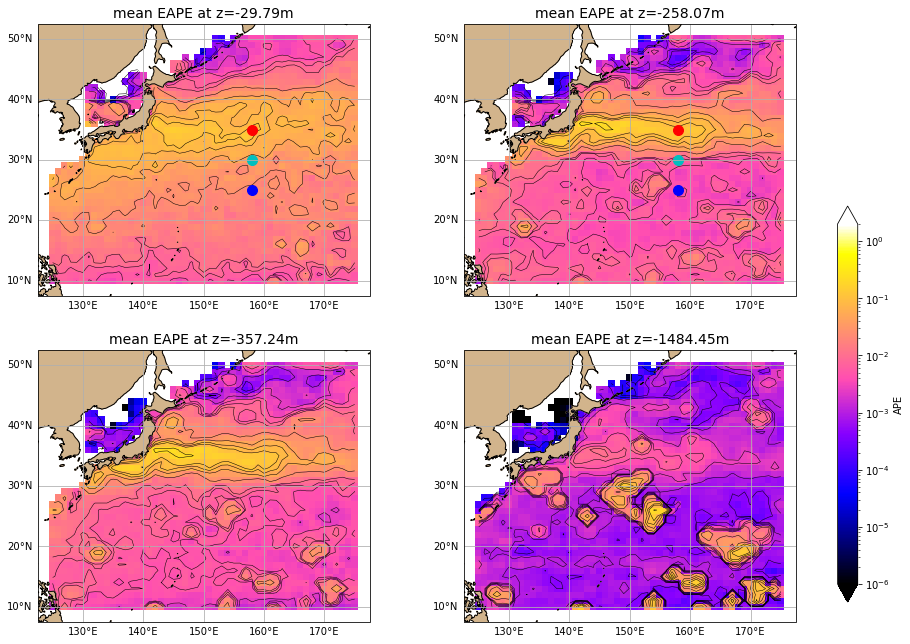

In [58]:
this_z = [3, 26, 36, 150]
print(z_grid[this_z])
tcmap = plt.get_cmap('gnuplot2')
data_coords = {'latitude': cen_lat, 'longitude': cen_lon}
# lon_xr = np.where((lon_bins[1:-1] > lon_w) & (lon_bins[1:-1] < lon_e))[0]
# lat_xr = np.where((lat_bins[1:-1] > lat_s) & (lat_bins[1:-1] < lat_n))[0]
# lev = np.arange(0.001, 0.1, 0.001)
ape_levs = np.concatenate((np.arange(0.0001,0.01,0.002),np.arange(0.01,0.1,0.01),np.arange(0.1,50,0.1)))
ape_levs = [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 10]

f, ax = plt.subplots(2,2,figsize=(14,11),\
                     subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
gax = ax.flatten()
for i in range(len(gax)):
    ape_plot = np.transpose(ape2[:, :, this_z[i]].copy())
    ape_plot[float_den <= 15] = np.nan
    ape_xr = xr.DataArray(data=ape_plot, \
                                      name='ape', dims=['latitude', 'longitude'], coords=data_coords)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    ape_ax = ape_xr.plot(ax=gax[i],transform=ccrs.PlateCarree(), norm=LogNorm(vmin=0.000001, vmax=2),\
                         cmap=tcmap, zorder=0, add_colorbar=False)
    ape_xr.plot.contour(ax=gax[i],transform=ccrs.PlateCarree(), \
                                 levels=ape_levs, \
                                 zorder=1, add_colorbar=False, colors='k', linewidths=0.5)
    gax[i].set_extent([c_lon_o[0] - 2.5, c_lon_o[-1] + 2.5, \
                   c_lat_o[0] - 2.5, c_lat_o[-1] + 2.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gax[i].set_title('mean EAPE at z=' + str(np.round(z_grid[this_z[i]],2)) + 'm', fontsize=14)
    gl.xlabels_top = False
    gl.ylabels_right = False

this_lon=33 # 45
this_lat=20 # 40
for i in range(2):
    gax[i].scatter(lon_grid[this_lat,this_lon],lat_grid[this_lat,this_lon],color='c',s=100)
    gax[i].scatter(lon_grid[this_lat+5,this_lon],lat_grid[this_lat+5,this_lon],color='r',s=100)
    gax[i].scatter(lon_grid[this_lat-5,this_lon],lat_grid[this_lat-5,this_lon],color='b',s=100)
cbpos = [0.93, 0.15, 0.02, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(ape_ax, cax=cax, orientation='vertical', extend='both', label='APE')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_01/eape_1yr.jpg', dpi=550)
# f.savefig('/Users/jakesteinberg/Desktop/sample_eape_winter.jpg', dpi=550)


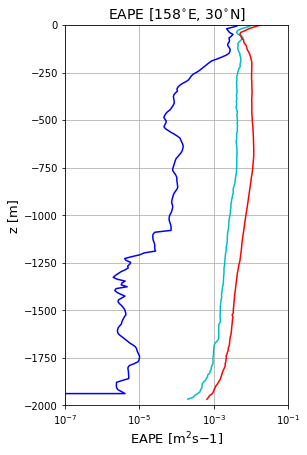

In [60]:
f, ax = plt.subplots(1,1,figsize=(4,7))
ax.plot(ape2[this_lat, this_lon],z_grid,color='c')
ax.plot(ape2[this_lat+4, this_lon],z_grid,color='r')
ax.plot(ape2[this_lat-4, this_lon],z_grid,color='b')
ax.set_title('EAPE [' + str(lon_grid[0,this_lon]) + '$^{\circ}$E, ' + str(lat_grid[this_lat,0]) + '$^{\circ}$N]',fontsize=14)
ax.set_ylim([-2000, 0])
ax.set_xlim([0.0000001,0.1])
ax.set_xscale('log')
ax.set_ylabel('z [m]', fontsize=13)
ax.set_xlabel(r'EAPE [m$^2$s${-1}$]', fontsize=13)
ax.grid()
# f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_07_01/eape_1yr_profiles.jpg', dpi=550)



In [12]:
# -------------------------------
filename = ('/Users/jakesteinberg/Desktop/gridded_eape_nw_pacific_summer_allt_' + str(np.int(r)) + 'km_' + \
            this_year[0] + '_' + this_year[-1] + '.nc')
ds = xr.Dataset(
    data_vars=dict(
        eape1=(["lon", "lat", "z"], ape2),
        eape2=(["lon", "lat", "z"], ape3),
        mean_rho=(["lon", "lat", "z"], mean_rho),
        mean_t_on_rho=(["lon", "lat", "rho"], mean_t_on_rho),
        mean_s_on_rho=(["lon", "lat", "rho"], mean_s_on_rho),
    ),
    coords=dict(
        pressure=(["z"], p_grid),
        density=(["rho"], rho_grid),
        latitude=(["lat"], cen_lat),
        longitude=(["lon"], cen_lon),
    ),
)
ds.to_netcdf(path=filename)

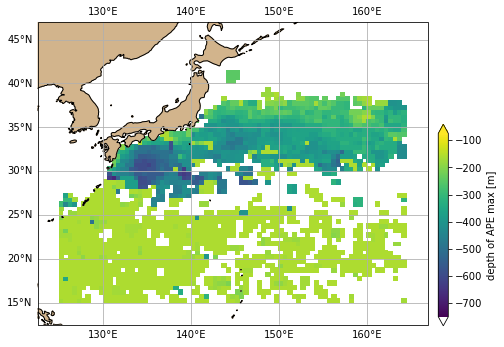

In [27]:
f, ax = plt.subplots(1,1,figsize=(7,7),\
                     subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
fd = ax.pcolor(cen_lon,cen_lat,np.transpose(dep_of_max),transform=ccrs.PlateCarree(),vmin=-750, vmax=-75)
ax.set_extent([c_lon_out[0] - 2.5, c_lon_out[-1] + 2.5, c_lat_out[0] - 2.5, c_lat_out[-1] + 2.5], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.ylabels_right = False
cbpos = [0.92, 0.2, 0.02, 0.4]
cax = f.add_axes(cbpos)
cb = f.colorbar(fd, cax=cax, orientation='vertical', extend='both', label='depth of APE max [m]')
# ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()

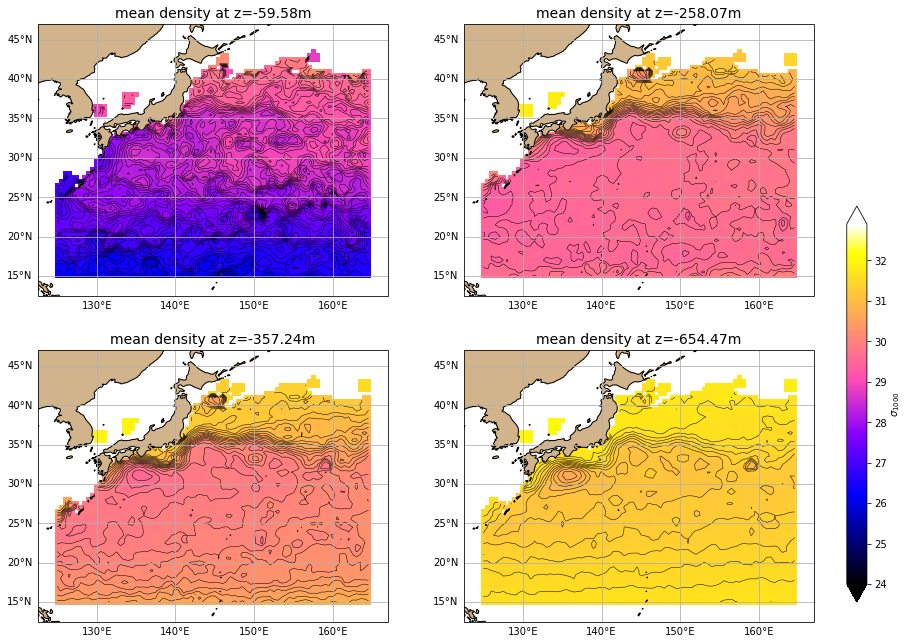

In [108]:
rho_levs = np.arange(24,33,0.1)
f, ax = plt.subplots(2,2,figsize=(14,11),\
                     subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
gax = ax.flatten()
for i in range(len(gax)):
    mr_xr = xr.DataArray(data=np.transpose(mean_rho[:, :, this_z[i]]), \
                                      name='mean_rho', dims=['latitude', 'longitude'], coords=data_coords)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    ape_ax = mr_xr.plot(ax=gax[i],transform=ccrs.PlateCarree(), vmin=rho_levs[0], vmax=rho_levs[-1],\
                         cmap=tcmap, zorder=0, add_colorbar=False)
    mr_xr.plot.contour(ax=gax[i],transform=ccrs.PlateCarree(), \
                                 levels=rho_levs, zorder=1, add_colorbar=False, colors='k', linewidths=0.5)
    gax[i].set_extent([c_lon_out[0] - 2.5, c_lon_out[-1] + 2.5, \
                   c_lat_out[0] - 2.5, c_lat_out[-1] + 2.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gax[i].set_title('mean density at z=' + str(np.round(z_grid[this_z[i]],2)) + 'm', fontsize=14)
    gl.xlabels_top = False
    gl.ylabels_right = False
cbpos = [0.93, 0.15, 0.02, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(ape_ax, cax=cax, orientation='vertical', extend='both', label='$\sigma_{1000}$')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_04_30/sample_rhobar.jpg', dpi=550)

In [96]:
np.nanmin(mean_t_var_on_rho)

0.13029276549432156

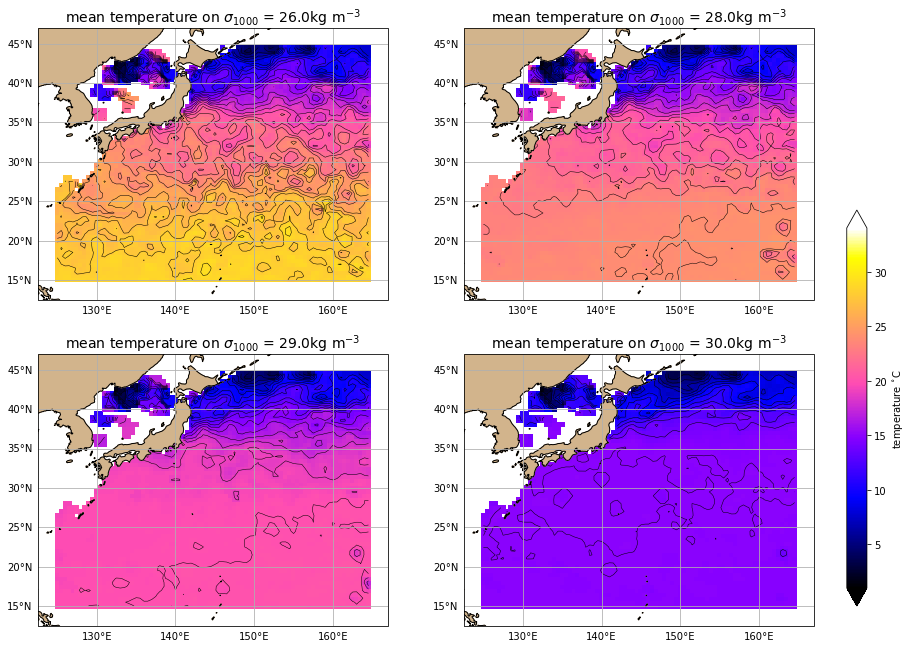

In [112]:
this_rho = [20, 40, 50, 60]
t_rho_levs = np.arange(1,35,1)
# s_rho_levs = np.arange(0.001,10,5)

tcmap = plt.get_cmap('gnuplot2')
data_coords = {'latitude': cen_lat, 'longitude': cen_lon}
f, ax = plt.subplots(2,2,figsize=(14,11),subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
gax = ax.flatten()
for i in range(len(gax)):
    mr_xr = xr.DataArray(data=np.transpose(mean_t_var_on_rho[:, :, this_rho[i]]), \
                                      name='mean_t_on_rho', dims=['latitude', 'longitude'], coords=data_coords)
    gax[i].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
    gax[i].coastlines()
    ape_ax = mr_xr.plot(ax=gax[i],transform=ccrs.PlateCarree(), \
                        vmin=t_rho_levs[0], vmax=t_rho_levs[-1],\
                        cmap=tcmap, zorder=0, add_colorbar=False)
    mr_xr.plot.contour(ax=gax[i],transform=ccrs.PlateCarree(), \
                                 levels=t_rho_levs, zorder=1, add_colorbar=False, colors='k', linewidths=0.5)
    gax[i].set_extent([c_lon_out[0] - 2.5, c_lon_out[-1] + 2.5, \
                   c_lat_out[0] - 2.5, c_lat_out[-1] + 2.5], crs=ccrs.PlateCarree())
    gl = gax[i].gridlines(draw_labels=True)
    gax[i].set_title(r'mean temperature on $\sigma_{1000}$ = ' + str(np.round(rho_grid[this_rho[i]],3)) + 'kg m$^{-3}$', fontsize=14)
    gl.xlabels_top = False
    gl.ylabels_right = False
cbpos = [0.93, 0.15, 0.02, 0.5]
cax = f.add_axes(cbpos)
cb = f.colorbar(ape_ax, cax=cax, orientation='vertical', extend='both', label='temperature $^{\circ}$C')
f.savefig('/Users/jakesteinberg/Documents/CPT/meetings/2021_04_30/sample_t_on_rho.jpg', dpi=550)

In [191]:
# (rho - rho_bar)/(drho_dz)
rho_bar = np.nanmean(rho1000,axis=1)
rho_prime = rho1000 - np.tile(rho_bar[:, None],(1,count))
drho_dz = np.nan * np.ones(np.shape(rho_bar))
drho_dz[1:-1] = (rho_bar[2:] - rho_bar[0:-2])/(z_grid[2]-z_grid[0])
eta = np.nan*np.ones(np.shape(rho_prime))
for i in range(count):
    eta[:, i] = (rho1000[:,i] - rho_bar)/drho_dz
ape = (-9.81/(2*1000))*eta*rho_prime

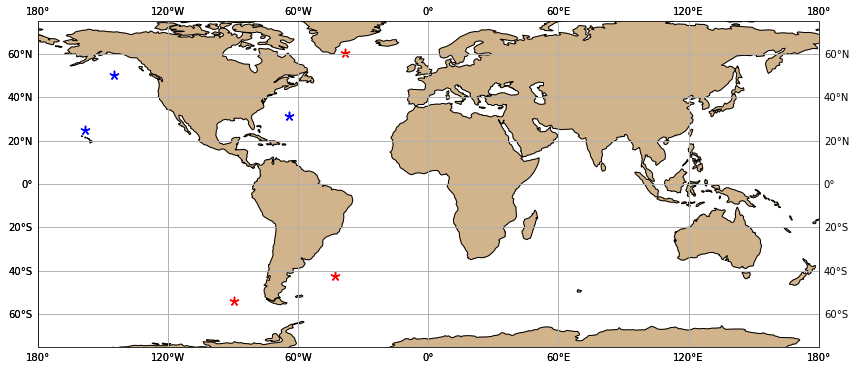

In [225]:
# map of relevant data 
f, ax = plt.subplots(1,1,figsize=(14,10),\
                     subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
# fd = ax.pcolor(cen_lon,cen_lat,np.transpose(dep_of_max),transform=ccrs.PlateCarree(),vmin=-750, vmax=-75)
ax.scatter(-64.166, 31.5, transform=ccrs.PlateCarree(), s=70, marker=(5,2),zorder=2, color='b')
ax.scatter(-158, 24.75, transform=ccrs.PlateCarree(), s=70, marker=(5,2),zorder=2,color='b')
ax.scatter(-144.9, 50.1, transform=ccrs.PlateCarree(), s=70, marker='d',zorder=2,color='r')
ax.scatter(-144.9, 50.1, transform=ccrs.PlateCarree(), s=70, marker=(5,2),zorder=2,color='b')
ax.scatter(-42.89, -42.5, transform=ccrs.PlateCarree(), s=70, marker='d',zorder=2,color='r')
ax.scatter(-38.44, 60.45, transform=ccrs.PlateCarree(), s=70, marker='d',zorder=2,color='r')
ax.scatter(-89.66, -54.08, transform=ccrs.PlateCarree(), s=70, marker='d',zorder=2,color='r')
ax.set_extent([-180, 180, -75, 75], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.ylabels_right = False
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1)
ax.coastlines()
# f.savefig('/Users/jakesteinberg/Documents/CPT/moorings/mooring_ref.jpg', dpi=550)

In [ ]:
# PAPA: 2018/07/24 - 2019/05/10 (170dbar to bottom) (u,v,w,T,S,p) (profiles near daily)
# ARG: 
# BATS: 